In [1]:
import json
import numpy as np
import numpy.random as random
import matplotlib.pyplot as plt
from scipy.stats import *
from collections import defaultdict
from utils import get_session_ids, get_all_sequences, get_topics, get_sub_topics, RegExp, product,to_matrix
from search_engine import *
from numpy.random import choice
from tqdm.notebook import tqdm

np.set_printoptions(precision=3)

In [2]:
path_log = './data/log.2.tsv'
path_topic = './data/topic.tsv'
path_sub_topic = './data/sub_topic.tsv'
path_retrievable_paragraph = './data/retrievable_paragraph.tsv'

In [3]:
session_ids = get_session_ids(path_log)
all_sequences = get_all_sequences(path_log, session_ids)

In [4]:
topics = get_topics(path_topic)

#topics

In [5]:
# topic -> sub_topic -> queries
all_queries = {}

for topic in all_sequences:
    
    queries = defaultdict(list)
    for sequence in all_sequences[topic]:
        for action in sequence:
            sub_topic = action[3]
            query = action[4]
            queries[sub_topic].append(query)
    
    all_queries[topic] = queries

#all_queries

In [6]:
# topic -> sub_topic -> paragraphs
qrels = defaultdict(dict)

sub_topic_to_paragraph = defaultdict(set)
with open(path_retrievable_paragraph) as f:
    for line in f.readlines()[1:]:
        items = line.split('\t')
        sub_topic = int(items[0])
        paragraph = int(items[1])
        sub_topic_to_paragraph[sub_topic].add(paragraph)

sub_topics = get_sub_topics(path_sub_topic)

for topic in sub_topics:
    for sub_topic in sub_topics[topic]:
        qrels[topic][sub_topic] = sub_topic_to_paragraph[sub_topic]

#qrels

In [7]:
# from users binary
# topic -> sub_topic -> paragraphs
qrels_users = {}

for topic in sub_topics:
    for sequence in all_sequences[topic]:
        for action in sequence:
            paragraph = action[1]
            rel = action[2]
            sub_topic = action[3]
            if rel == 'relevant':
                if topic not in qrels_users:
                    qrels_users[topic] = {}
                if sub_topic not in qrels_users[topic]:
                    qrels_users[topic][sub_topic] = set()
                qrels_users[topic][sub_topic].add(paragraph)

#qrels_users

In [8]:
# from users continuos
# topic -> sub_topic -> paragraphs
qrels_users = {}

for topic in sub_topics:
    for sequence in all_sequences[topic]:
        for action in sequence:
            paragraph = action[1]
            rel = action[2]
            sub_topic = action[3]
            if topic not in qrels_users:
                qrels_users[topic] = {}
            if sub_topic not in qrels_users[topic]:
                qrels_users[topic][sub_topic] = {}
            if paragraph not in qrels_users[topic][sub_topic]:
                qrels_users[topic][sub_topic][paragraph] = (0, 0)
            num, den = qrels_users[topic][sub_topic][paragraph]
            if rel == 'relevant':
                qrels_users[topic][sub_topic][paragraph] = (num + 1, den + 1)
            else:
                qrels_users[topic][sub_topic][paragraph] = (num, den + 1)

for topic in qrels_users:
    for sub_topic in qrels_users[topic]:
        for paragraph in qrels_users[topic][sub_topic]:
            num, den = qrels_users[topic][sub_topic][paragraph]
            qrels_users[topic][sub_topic][paragraph] = num/den
            
#qrels_users

In [9]:
direct_index = DirectIndex.load()

In [10]:
pre_preocessor = PreProcessor()

def select_random_documents(documents:set, p:float=0.0):
    assert(0.0 <= p <= 1.0)
    if p == 0.0:
        return set()
    elif p == 1.0:
        return documents
    else:
        return set(choice(list(documents), replace=False, size = int(len(documents) * p)))
        
def get_search_engine(topic, sub_topic, qrels, direct_index, noise = 0.0):
    # select documents belonging to the topic
    selected_documents = {}
    for document in qrels[topic][sub_topic]:
        selected_documents[document] = direct_index.index[document]
        
    # select random documents
    # 1. from topic documents
    topic_documents = set()
    for _, sub_topic_documents in qrels[topic].items():
        topic_documents.update(sub_topic_documents)    
    topic_documents = select_random_documents(topic_documents, noise)
    
    for document in topic_documents:
        selected_documents[document] = direct_index.index[document]
    
    # 2. from all_documents
    all_documents = direct_index.index.keys()
    all_documents = select_random_documents(all_documents, noise)

    for document in all_documents:
        selected_documents[document] = direct_index.index[document]
        
    # retrievable documents
    inverted_index = InvertedIndex()
    inverted_index.create(selected_documents)
        
    return selected_documents, inverted_index

# stats
inverted_index = InvertedIndex()
inverted_index.create(direct_index.index)

# test
for topic in sub_topics:
    for sub_topic in sub_topics[topic]:
        print(topic, topics[topic], sub_topic)
        r_documents, r_inverted_index = get_search_engine(topic, sub_topic, qrels, direct_index, 0.01)
        print("over", len(r_documents), "documents")
        r_inverted_index.cl = inverted_index.cl
        r_inverted_index.dictionary = inverted_index.dictionary
        search = Search(r_inverted_index, pre_preocessor)
        print(search.search('amazon', n=2, retrievable_paragraphs=r_documents.keys()))
    break

10 amazon rainforest 1
over 204 documents
[374, 372]
10 amazon rainforest 2
over 202 documents
[371, 86]
10 amazon rainforest 3
over 205 documents
[381, 379]
10 amazon rainforest 4
over 204 documents
[386, 98]
10 amazon rainforest 5
over 203 documents
[371, 10163]


# Correlation Analysis

In [11]:
# CP

def dd_cp(alpha = None, m = None, l = None):
    return 1

def dd_ncp(alpha, m, l):
    return dd_cp()/l

def ncp(sequence):
    res = 0.0
    for action in sequence:
        if action[2] == 'relevant':
            res += dd_ncp(None, None, len(sequence))
    return res

def get_ncp_list(sequences):
    res = []
    for sequence in sequences:
        res.append(ncp(sequence))
    return res

# CBP

def dd_cbp(alpha, m, l = None):
    return alpha ** m

def dd_ncbp(alpha, m, l):
    norm = 0.0
    for i in range(l):
        norm += dd_cbp(alpha, i, l)
    return dd_cbp(alpha, m, l) / norm

def ncbp(sequence, alpha):
    res = 0.0
    for m, action in enumerate(sequence):
        if action[2] == 'relevant':
            res += dd_ncbp(alpha, m, len(sequence))
    return res

def get_ncbp_list(sequences, alpha):
    res = []
    for sequence in sequences:
        res.append(ncbp(sequence, alpha))
    return res

# CBP +

def dd_cbp_p(alpha, beta, m, sequence):
    res = 1.0
    for action in sequence[:m]:
        if action[2] == 'relevant':
            res *= alpha
        else:
            res *= beta
    return res

def dd_ncbp_p(alpha, beta, m, sequence):
    res = dd_cbp_p(alpha, beta, m, sequence)
    norm = 0.0
    for i in range(len(sequence)):
        norm += dd_cbp(alpha, i, len(sequence))
    return res/norm

def ncbp_p(sequence, alpha, beta):
    res = 0.0
    for m, action in enumerate(sequence):
        if action[2] == 'relevant':
            res += dd_ncbp_p(alpha, beta, m, sequence)
    return res

def get_ncbp_p_list(sequences, alpha, beta):
    res = []
    for sequence in sequences:
        res.append(ncbp_p(sequence, alpha, beta))
    return res

In [12]:
ncbp_p_scores = []
ncbp_scores = []
ncp_scores = []

for topic in topics:
    sequences = all_sequences[topic]
    ncbp_p_scores.append((topic, np.mean(get_ncbp_p_list(sequences, 1.0, 0.53))))
    ncbp_scores.append((topic, np.mean(get_ncbp_list(sequences, 0.8))))
    ncp_scores.append((topic, np.mean(get_ncp_list(sequences))))
    
ncbp_p_scores = sorted(ncbp_p_scores)
ncbp_scores = sorted(ncbp_scores)
ncp_scores = sorted(ncp_scores)

#ncbp_p_scores, ncbp_scores, ncp_scores

In [13]:
# new version
def get_satisfaction(lines):
    reg_exp = RegExp()
    satisfaction = None
    for line in lines:
        items = line.split('\t')
        content = items[2]
        if reg_exp.get(r'user is (.+)', content):
            satisfaction = reg_exp.res
    return satisfaction

# new
def get_all_satisfactions(path_log, session_ids):
    res = defaultdict(list)
    for session_id in session_ids:
        selected_lines = []
        with open(path_log) as f:
            for line in f.readlines()[1:]:
                items = line.split('\t')
                user = items[3].strip()
                topic = int(items[4].strip())
                if user == session_id[0] and topic == session_id[1]:
                    selected_lines.append(line)

        satisfaction = get_satisfaction(selected_lines)
        res[session_id[1]].append(satisfaction)
    return res

all_satisfactions = get_all_satisfactions(path_log, session_ids)
#all_satisfactions

In [14]:
satisfaction_scores = []
for topic in topics:
    satisfactions = all_satisfactions[topic]
    satisfaction_score = 0.0
    for satisfaction in satisfactions:
        if satisfaction == 'satisfied':
            satisfaction_score += 1
    satisfaction_score /= len(satisfactions)
    satisfaction_scores.append((topic, satisfaction_score))

satisfaction_scores = sorted(satisfaction_scores)
#satisfaction_scores

KendalltauResult(correlation=0.7339758434175737, pvalue=0.001787289036987269)
SpearmanrResult(correlation=0.870161710874372, pvalue=0.0004954180897534654)


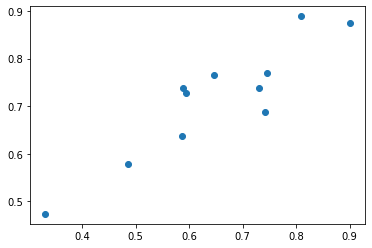

In [15]:
plt.plot([i[1] for i in ncbp_p_scores], [i[1] for i in satisfaction_scores], 'o')
print(kendalltau([i[1] for i in ncbp_p_scores], [i[1] for i in satisfaction_scores]))
print(spearmanr([i[1] for i in ncbp_p_scores], [i[1] for i in satisfaction_scores]))
#print(pearsonr([i[1] for i in ncbp_p_scores], [i[1] for i in satisfaction_scores]))

KendalltauResult(correlation=0.7339758434175737, pvalue=0.001787289036987269)
SpearmanrResult(correlation=0.8610500699228079, pvalue=0.0006630680655063411)


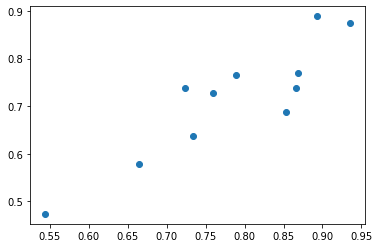

In [16]:
plt.plot([i[1] for i in ncbp_scores], [i[1] for i in satisfaction_scores], 'o')
print(kendalltau([i[1] for i in ncbp_scores], [i[1] for i in satisfaction_scores]))
print(spearmanr([i[1] for i in ncbp_scores], [i[1] for i in satisfaction_scores]))
#print(pearsonr([i[1] for i in ncbp_scores], [i[1] for i in satisfaction_scores]))

KendalltauResult(correlation=0.697277051246695, pvalue=0.0030042622393982835)
SpearmanrResult(correlation=0.8382709675438977, pvalue=0.0012683508950782564)


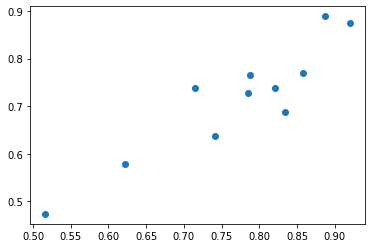

In [17]:
plt.plot([i[1] for i in ncp_scores], [i[1] for i in satisfaction_scores], 'o')
print(kendalltau([i[1] for i in ncp_scores], [i[1] for i in satisfaction_scores]))
print(spearmanr([i[1] for i in ncp_scores], [i[1] for i in satisfaction_scores]))
#print(pearsonr([i[1] for i in ncp_scores], [i[1] for i in satisfaction_scores]))

In [18]:
for topic in sub_topics:
    for sub_topic in sub_topics[topic]:
        print(topic, topics[topic], sub_topic)
        r_documents, r_inverted_index = get_search_engine(topic, sub_topic, qrels, inverted_index, 0.0)
        r_inverted_index.cl = inverted_index.cl
        r_inverted_index.dictionary = inverted_index.dictionary
        search = Search(r_inverted_index, pre_preocessor)
        print(search.search('amazon', n=2, retrievable_paragraphs=r_documents.keys()))
    break

10 amazon rainforest 1
[372]
10 amazon rainforest 2
[371]
10 amazon rainforest 3
[379]
10 amazon rainforest 4
[385]
10 amazon rainforest 5
[371]


# Simulations

In [19]:
def generate_sequence(num_subtopics, min_sub_topics = 1):
    prob = 1.0
    sequence = []
    current_subtopic = 0
    
    next_subtopic = choice(range(1, num_subtopics + 1), 1)[0]
    prob *= 1.0/num_subtopics
    sequence.append((current_subtopic, None, None, next_subtopic + min_sub_topics - 1, None))
    current_subtopic = next_subtopic
    
    while next_subtopic + min_sub_topics - 1 != num_subtopics + 1 + min_sub_topics - 1:
        next_subtopic = choice(range(1, num_subtopics + 2), 1)[0]
        prob *= 1.0/(num_subtopics + 1)
        sequence.append((current_subtopic + min_sub_topics - 1, 
                         None, None, 
                         next_subtopic + min_sub_topics - 1, None))
        current_subtopic = next_subtopic
        
    return sequence, prob

sequence, prob = generate_sequence(5)

print(sequence)

print(sequence[:-1])

[(0, None, None, 5, None), (5, None, None, 1, None), (1, None, None, 3, None), (3, None, None, 3, None), (3, None, None, 4, None), (4, None, None, 1, None), (1, None, None, 3, None), (3, None, None, 2, None), (2, None, None, 6, None)]
[(0, None, None, 5, None), (5, None, None, 1, None), (1, None, None, 3, None), (3, None, None, 3, None), (3, None, None, 4, None), (4, None, None, 1, None), (1, None, None, 3, None), (3, None, None, 2, None)]


In [20]:
def get_transitions_table(num_subtopics, min_sub_topic, sequences, epsilon = 0.0):
    transitions_table = defaultdict(float)
    for sequence in sequences:
        last_key = None
        for n, action in enumerate(sequence):
            if n == 0:
                key = (action[0], action[3] - min_sub_topic + 1)
            else:
                key = (action[0] - min_sub_topic + 1, action[3] - min_sub_topic + 1)
            transitions_table[key] += 1
            last_key = key
        transitions_table[(last_key[1], num_subtopics+1)] += 1
    
    norms = defaultdict(float)
    for from_subtopic, to_subtopic in product(range(num_subtopics+1), range(1, num_subtopics+2)):
        if not (from_subtopic == 0 and to_subtopic == num_subtopics + 1):            
            transitions_table[(from_subtopic, to_subtopic)] += epsilon
        norms[from_subtopic] += transitions_table[(from_subtopic, to_subtopic)]
    
    for from_subtopic, to_subtopic in product(range(num_subtopics+1), range(1, num_subtopics+2)):
        if norms[from_subtopic] > 0.0:
            transitions_table[(from_subtopic, to_subtopic)] /= norms[from_subtopic]
            
    return transitions_table

#get_transitions_table(len(sub_topics[1]), min(sub_topics[1]), all_sequences[1])

def generate_sequence_from_table(num_subtopics, min_sub_topics, table):
    prob = 1.0
    table = to_matrix(table)
    sequence = []
    current_subtopic = 0
    
    next_subtopic = choice(range(1, num_subtopics + 2), 1, p=table[0])[0]
    prob *= table[0, next_subtopic - 1]
    sequence.append((current_subtopic, None, None, next_subtopic + min_sub_topics - 1, None))
    current_subtopic = next_subtopic
    
    while next_subtopic + min_sub_topics - 1 != num_subtopics + 1 + min_sub_topics - 1:
        next_subtopic = choice(range(1, num_subtopics + 2), 1, p=table[current_subtopic])[0]
        prob *= table[current_subtopic, next_subtopic-1]
        sequence.append((current_subtopic + min_sub_topics - 1, 
                         None, None, 
                         next_subtopic + min_sub_topics - 1, None))
        current_subtopic = next_subtopic
    
    return sequence, prob
    
transitions_table = get_transitions_table(len(sub_topics[1]), min(sub_topics[1]), all_sequences[1])
#generate_sequence_from_table(len(sub_topics[1]), min(sub_topics[1]), transitions_table)

In [21]:
def get_transitions_tables(num_subtopics, min_sub_topic, sequences, epsilon = 0.0):
    rel_transitions_table = defaultdict(float)
    irr_transitions_table = defaultdict(float)
    p_rel = defaultdict(float)
    p_irr = defaultdict(float)
    for sequence in sequences:
        last_key = None
        last_rel = 'irrelevant'
        for n, action in enumerate(sequence):
            if n == 0:
                key = (action[0], action[3] - min_sub_topic + 1)
            else:
                key = (action[0] - min_sub_topic + 1, action[3] - min_sub_topic + 1)
            if last_rel == 'relevant':
                rel_transitions_table[key] += 1
                p_rel[key[0]] += 1
            else:
                irr_transitions_table[key] += 1
                p_irr[key[0]] += 1
            last_key = key
            last_rel = action[2]
        
        if last_rel == 'relevant':
            rel_transitions_table[(last_key[1], num_subtopics+1)] += 1
            p_rel[last_key[1]] += 1
        else:
            irr_transitions_table[(last_key[1], num_subtopics+1)] += 1
            p_irr[last_key[1]] += 1
        
    rel_norms = defaultdict(float)
    for from_subtopic, to_subtopic in product(range(num_subtopics+1), range(1, num_subtopics+2)):
        if from_subtopic > 0:            
            rel_transitions_table[(from_subtopic, to_subtopic)] += epsilon
        rel_norms[from_subtopic] += rel_transitions_table[(from_subtopic, to_subtopic)]
    
    irr_norms = defaultdict(float)
    for from_subtopic, to_subtopic in product(range(num_subtopics+1), range(1, num_subtopics+2)):
        if not (from_subtopic == 0 and to_subtopic == num_subtopics + 1):
            irr_transitions_table[(from_subtopic, to_subtopic)] += epsilon
        irr_norms[from_subtopic] += irr_transitions_table[(from_subtopic, to_subtopic)]
    
    for from_subtopic, to_subtopic in product(range(num_subtopics+1), range(1, num_subtopics+2)):
        if rel_norms[from_subtopic] > 0.0:
            rel_transitions_table[(from_subtopic, to_subtopic)] /= (rel_norms[from_subtopic]) 
    
    for from_subtopic, to_subtopic in product(range(num_subtopics+1), range(1, num_subtopics+2)):
        if irr_norms[from_subtopic] > 0.0:
            irr_transitions_table[(from_subtopic, to_subtopic)] /= (irr_norms[from_subtopic])
    
    p = []
    for t in range(num_subtopics + 1):
        if (p_rel[t] + p_irr[t]) > 0:
            p.append(p_rel[t]/(p_rel[t] + p_irr[t]))
        else:
            p.append(0.0)
    p = np.array([p])

    return rel_transitions_table, irr_transitions_table, p, 1 - p

t1, t2, p_rel, p_irr = get_transitions_tables(len(sub_topics[1]), min(sub_topics[1]), all_sequences[1], 0.0)

#print(p_rel, p_irr)
#print(to_matrix(transitions_table))
#print(to_matrix(t1)) 
#print(to_matrix(t2))
#print((to_matrix(t1).T * p_rel).T + (to_matrix(t2).T * p_irr).T)

In [22]:
class SequenceGenerator:
    
    def __init__(self, num_subtopics, min_sub_topic, rel_table, irr_table):
        self.num_subtopics = num_subtopics
        self.rel_table = to_matrix(rel_table)
        self.irr_table = to_matrix(irr_table)
        self.min_sub_topic = min_sub_topic
        self.relevance = False
        self.current_subtopic = 0
        
    def __iter__(self):
        #self.current_subtopic = 0
        return self
    
    def set_relevance(self, relevance):
        self.relevance = relevance
    
    def __next__(self):
        next_subtopic = -1
        prob = -1
        if self.current_subtopic + self.min_sub_topic - 1 == self.num_subtopics + 1 + self.min_sub_topic - 1:
            raise StopIteration
        if self.relevance:
            #print(self.rel_table[self.current_subtopic].sum())
            next_subtopic = choice(range(1, self.num_subtopics + 2), 1, p=self.rel_table[self.current_subtopic])[0]
            prob = self.rel_table[self.current_subtopic, next_subtopic - 1]
        else:
            #print(self.irr_table[self.current_subtopic].sum())
            next_subtopic = choice(range(1, self.num_subtopics + 2), 1, p=self.irr_table[self.current_subtopic])[0]
            prob = self.irr_table[self.current_subtopic, next_subtopic - 1]
        self.current_subtopic = next_subtopic
        return next_subtopic + self.min_sub_topic - 1, prob
    
#sg = SequenceGenerator(len(sub_topics[1]), min(sub_topics[1]), t1, t2)
#for i in sg:
#    print(i)
#    sg.set_relevance(True)

## Log Total Sum Error 

In [23]:
def ltse(d1, d2):
    err = 0.0
    M = len(d1)
    if len(d1) < len(d2):
        d1, d2 = d2, d1
    for i in range(len(d1)):
        if i < len(d2):
            err += abs(d1[i]-d2[i])**2   
        else:
            err += abs(d1[i])**2
    return np.log(err)

In [24]:
gp = defaultdict(int)
for topic in all_sequences:
    for sequence in all_sequences[topic]:
        for m, _ in enumerate(sequence):
            gp[m] += 1

ngp = np.array([value for key, value in gp.items()])
ngp = ngp / np.sum(ngp)

ngp

array([0.184, 0.167, 0.159, 0.143, 0.118, 0.081, 0.054, 0.035, 0.023,
       0.012, 0.008, 0.005, 0.005, 0.004, 0.002])

## Uniform Simulations

In [25]:
def dd_cp(alpha, beta, m, sequence, acc_value = 1.0):
    return 1

def dd_cbp(alpha, beta, m, sequence, acc_value = 1.0):
    if m == 0:
        return 1.0
    else:
        res = acc_value*alpha
        return res
    
def dd_cbp_p(alpha, beta, m, sequence, acc_value = 1.0):
    if m == 0:
        return 1.0
    else:
        res = acc_value
        action = sequence[m]
        if action[2] == 'relevant':
            res *= alpha
        else:
            res *= beta
        return res

In [26]:
num_samples = 5000

In [27]:
def get_uniform_sequences():
    res = {}
    for topic in tqdm(sub_topics):
        
        all_r_documents = {}
        all_r_inverted_index = {}
        for sub_topic in sub_topics[topic]:
            r_documents, r_inverted_index = get_search_engine(topic, sub_topic, qrels, direct_index)
            all_r_documents[sub_topic] = r_documents
            all_r_inverted_index[sub_topic] = r_inverted_index
        
        sequences = []
        for _ in range(num_samples):
            sequence, prob = generate_sequence(len(sub_topics[topic]), min(sub_topics[topic]))
            for m, action in enumerate(sequence[:-1]):
                query = ''
                if sub_topic in all_queries[topic] and len(all_queries[topic][sub_topic]) > 0: 
                    queries = list(all_queries[topic][sub_topic])
                    query = queries[choice(range(len(queries)))]

                search = Search(all_r_inverted_index[sub_topic], pre_preocessor)
                answer = search.search(query, n=1, retrievable_paragraphs=all_r_documents[sub_topic].keys())[0]

                if sub_topic in qrels_users[topic] and answer in qrels_users[topic][sub_topic] and \
                np.random.uniform(0,1) < qrels_users[topic][sub_topic][answer]:
                    sequence[m] = (action[0], answer, 'relevant', action[3], query)
                else:
                    sequence[m] = (action[0], answer, 'irrelevant', action[3], query)
                
            sequences.append((sequence[:-1], prob))
            
        res[topic] = sequences
        
    return res

all_uniform_sequences = get_uniform_sequences()

In [28]:
def get_dist(all_sequences, alpha, beta, dd):#, with_prob = True):
    res = defaultdict(float)
    n = defaultdict(float)
    for topic in sub_topics:
        for sequence, prob in all_sequences[topic]:
            score = 1.0
            #if not with_prob:
            #prob = 1.0
            for m, _ in enumerate(sequence):
                score = dd(alpha, beta, m, sequence, score)
                res[m] += score * prob
                n[m] += prob
    
    for m in res:
        res[m] /= n[m]
    
    nres = np.array([value for key, value in res.items()])
    nres = nres / np.sum(nres)
    return nres

In [29]:
ngp_u_cp = get_dist(all_uniform_sequences, None, None, dd_cp)
print("CP, LTSE", ltse(ngp, ngp_u_cp))

CP, LTSE -2.083150865992216


In [30]:
res = 100
max_alpha = 0.0
max_ltse = 0.0
ngp_u_cbp = None
for alpha in tqdm(range(0, res+1)):
    alpha /= res
    
    ngp_u = get_dist(all_uniform_sequences, alpha, None, dd_cbp)
            
    score = ltse(ngp, ngp_u)
    if score < max_ltse:
        max_ltse = score
        max_alpha = alpha
        ngp_u_cbp = ngp_u
        
print("CBP, LTSE", max_ltse, max_alpha)


CBP, LTSE -5.226785263336451 0.79


In [31]:
res = 10
max_alpha = 0.0
max_beta = 0.0
max_ltse = 0.0
ngp_u_cbp_p = None
for alpha in tqdm(range(0, res+1)):
    alpha /= res
    
    for beta in range(0, res+1):
        beta /= res
        
        ngp_u = get_dist(all_uniform_sequences, alpha, beta, dd_cbp_p)

        score = ltse(ngp, ngp_u)
        if score < max_ltse:
            max_ltse = score
            max_alpha = alpha
            max_beta = beta
            ngp_u_cbp_p = ngp_u
        
print("CBP, LTSE", max_ltse, max_alpha, max_beta)


CBP, LTSE -5.394267089782535 0.9 0.6


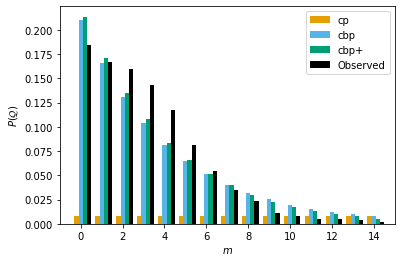

In [32]:
x = np.arange(ngp.shape[0])

bar_width = 0.20

plt.bar(x-bar_width*1, ngp_u_cp[0:len(x)], width = bar_width, color='#E69F00', align='center', label='cp')
plt.bar(x+bar_width*0, ngp_u_cbp[0:len(x)], width = bar_width, color='#56B4E9', align='center', label='cbp')
plt.bar(x+bar_width*1, ngp_u_cbp_p[0:len(x)], width = bar_width, color='#009E73', align='center', label="cbp+")
plt.bar(x+bar_width*2, ngp, width = bar_width, color='black', align='center', label="Observed")

#plt.rc('font', size=13)
plt.ylabel('$P(\\mathcal{Q})$')
plt.xlabel('$m$')
plt.xlim(-1, 15)
plt.legend()
#plt.savefig("probability_of_querying.png", dpi=300)

## Markov Simulations

In [33]:
def get_table_sequences():
    res = {}
    for topic in tqdm(sub_topics):
        
        all_r_documents = {}
        all_r_inverted_index = {}
        for sub_topic in sub_topics[topic]:
            r_documents, r_inverted_index = get_search_engine(topic, sub_topic, qrels, direct_index)
            all_r_documents[sub_topic] = r_documents
            all_r_inverted_index[sub_topic] = r_inverted_index
            
        transitions_table = get_transitions_table(len(sub_topics[topic]), 
                                                  min(sub_topics[topic]), 
                                                  all_sequences[topic])
        
        sequences = []
        for _ in range(num_samples):
            sequence, prob = generate_sequence_from_table(len(sub_topics[topic]), 
                                                          min(sub_topics[topic]), 
                                                          transitions_table)
            for m, action in enumerate(sequence[:-1]):
                query = ''
                if sub_topic in all_queries[topic] and len(all_queries[topic][sub_topic]) > 0: 
                    queries = list(all_queries[topic][sub_topic])
                    query = queries[choice(range(len(queries)))]

                search = Search(all_r_inverted_index[sub_topic], pre_preocessor)
                answer = search.search(query, n=1, retrievable_paragraphs=all_r_documents[sub_topic].keys())[0]

                if sub_topic in qrels_users[topic] and answer in qrels_users[topic][sub_topic] and \
                np.random.uniform(0,1) < qrels_users[topic][sub_topic][answer]:
                    sequence[m] = (action[0], answer, 'relevant', action[3], query)
                else:
                    sequence[m] = (action[0], answer, 'irrelevant', action[3], query)
                
            sequences.append((sequence[:-1], prob))
            
        res[topic] = sequences
    return res

all_table_sequences = get_table_sequences()

In [34]:
#all_table_sequences

In [35]:
ngp_t_cp = get_dist(all_table_sequences, None, None, dd_cp)
print("CP, LTSE", ltse(ngp, ngp_t_cp))

CP, LTSE -2.1363387488785297


In [36]:
res = 100
max_alpha = 0.0
max_ltse = 0.0
ngp_t_cbp = None
for alpha in tqdm(range(0, res + 1)):
    alpha /= res
    
    ngp_t = get_dist(all_table_sequences, alpha, None, dd_cbp)
            
    score = ltse(ngp, ngp_t)
    if score < max_ltse:
        max_ltse = score
        max_alpha = alpha
        ngp_t_cbp = ngp_t
        
print("CBP, LTSE", max_ltse, max_alpha)


CBP, LTSE -5.226785529264626 0.79


In [37]:
res = 10
max_alpha = 0.0
max_beta = 0.0
max_ltse = 0.0
ngp_t_cbp_p = None
for alpha in tqdm(range(0, res+1)):
    alpha /= res
    
    for beta in range(0, res+1):
        beta /= res
        
        ngp_t = get_dist(all_table_sequences, alpha, beta, dd_cbp_p)

        score = ltse(ngp, ngp_t)
        if score < max_ltse:
            max_ltse = score
            max_alpha = alpha
            max_beta = beta
            ngp_t_cbp_p = ngp_t
        
print("CBP, LTSE", max_ltse, max_alpha, max_beta)


CBP, LTSE -5.236163161782522 0.9 0.5


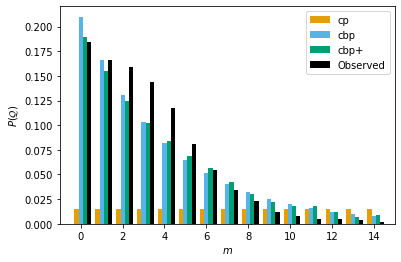

In [38]:
x = np.arange(ngp.shape[0])

bar_width = 0.20

plt.bar(x-bar_width*1, ngp_t_cp[0:len(x)], width = bar_width, color='#E69F00', align='center', label='cp')
plt.bar(x+bar_width*0, ngp_t_cbp[0:len(x)], width = bar_width, color='#56B4E9', align='center', label='cbp')
plt.bar(x+bar_width*1, ngp_t_cbp_p[0:len(x)], width = bar_width, color='#009E73', align='center', label="cbp+")
plt.bar(x+bar_width*2, ngp, width = bar_width, color='black', align='center', label="Observed")

#plt.rc('font', size=13)
plt.ylabel('$P(\\mathcal{Q})$')
plt.xlabel('$m$')
plt.xlim(-1, 15)
plt.legend()
#plt.savefig("probability_of_querying.png", dpi=300)

## Markov + Simulation

In [39]:
def get_double_table_sequences():
    res = {}
    for topic in tqdm(sub_topics):
        num_subtopics = len(sub_topics[topic])

        all_r_documents = {}
        all_r_inverted_index = {}
        for sub_topic in sub_topics[topic]:
            r_documents, r_inverted_index = get_search_engine(topic, sub_topic, qrels, direct_index)
            all_r_documents[sub_topic] = r_documents
            all_r_inverted_index[sub_topic] = r_inverted_index

        rel_table, irr_table, p_rel, _ = get_transitions_tables(num_subtopics, 
                                                                min(sub_topics[topic]), 
                                                                all_sequences[topic], 
                                                                0.001)
        sequences = []
        for _ in range(num_samples):
            sg = SequenceGenerator(num_subtopics, min(sub_topics[topic]), rel_table, irr_table)
            prob = 1.0
            prev_sub_topic = 0
            sequence = []
            for m, (sub_topic, prob_action) in enumerate(sg):
                if sub_topic != num_subtopics + 1 + min(sub_topics[topic]) - 1:
                    query = ''
                    if sub_topic in all_queries[topic] and len(all_queries[topic][sub_topic]) > 0: 
                        queries = list(all_queries[topic][sub_topic])
                        query = queries[choice(range(len(queries)))]

                    search = Search(all_r_inverted_index[sub_topic], pre_preocessor)
                    answer = search.search(query, 
                                           n=1, 
                                           retrievable_paragraphs=all_r_documents[sub_topic].keys())[0]
                    
                    if sub_topic in qrels_users[topic] and answer in qrels_users[topic][sub_topic] and \
                    np.random.uniform(0,1) < qrels_users[topic][sub_topic][answer]:
                        sg.set_relevance(True)
                        sequence.append((prev_sub_topic, answer, 'relevant', sub_topic, query))
                    else:
                        sg.set_relevance(False)
                        sequence.append((prev_sub_topic, answer, 'irrelevant', sub_topic, query))
                prev_sub_topic = sub_topic
                prob *= prob_action
                    
            sequences.append((sequence, prob))
        res[topic] = sequences

    return res

all_double_table_sequences = get_double_table_sequences()

In [40]:
ngp_t2_cp = get_dist(all_double_table_sequences, None, None, dd_cp)
print("CP, LTSE", ltse(ngp, ngp_t2_cp))

CP, LTSE -2.1488488391165097


In [41]:
res = 100
max_alpha = 0.0
max_ltse = 0.0
ngp_t2_cbp = None
for alpha in tqdm(range(0, res+1)):
    alpha /= res
    
    ngp_t2 = get_dist(all_double_table_sequences, alpha, None, dd_cbp)
            
    score = ltse(ngp, ngp_t2)
    if score < max_ltse:
        max_ltse = score
        max_alpha = alpha
        ngp_t2_cbp = ngp_t2
        
print("CBP, LTSE", max_ltse, max_alpha)


CBP, LTSE -5.2267863573034585 0.79


In [42]:
res = 10
max_alpha = 0.0
max_beta = 0.0
max_ltse = 0.0
ngp_t2_cbp_p = None
for alpha in tqdm(range(0, res+1)):
    alpha /= res
    
    for beta in range(0, res+1):
        beta /= res
        
        ngp_t2 = get_dist(all_double_table_sequences, alpha, beta, dd_cbp_p)

        score = ltse(ngp, ngp_t2)
        if score < max_ltse:
            max_ltse = score
            max_alpha = alpha
            max_beta = beta
            ngp_t2_cbp_p = ngp_t2
        
print("CBP, LTSE", max_ltse, max_alpha, max_beta)


CBP, LTSE -5.916187616240445 1.0 0.3


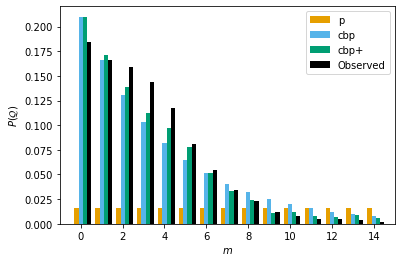

In [43]:
x = np.arange(ngp.shape[0])

bar_width = 0.20

plt.bar(x-bar_width*1, ngp_t2_cp[0:len(x)], width = bar_width, color='#E69F00', align='center', label='p')
plt.bar(x+bar_width*0, ngp_t2_cbp[0:len(x)], width = bar_width, color='#56B4E9', align='center', label='cbp')
plt.bar(x+bar_width*1, ngp_t2_cbp_p[0:len(x)], width = bar_width, color='#009E73', align='center', label="cbp+")
plt.bar(x+bar_width*2, ngp, width = bar_width, color='black', align='center', label="Observed")

#plt.rc('font', size=13)
plt.ylabel('$P(\\mathcal{Q})$')
plt.xlabel('$m$')
plt.xlim(-1, 15)
plt.legend()
#plt.savefig("probability_of_querying.png", dpi=300)

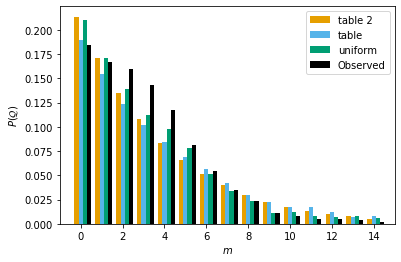

In [59]:
x = np.arange(ngp.shape[0])

bar_width = 0.20

plt.bar(x-bar_width*1, ngp_u_cbp_p[0:len(x)], width = bar_width, color='#E69F00', align='center', label='table 2')
plt.bar(x+bar_width*0, ngp_t_cbp_p[0:len(x)], width = bar_width, color='#56B4E9', align='center', label='table')
plt.bar(x+bar_width*1, ngp_t2_cbp_p[0:len(x)], width = bar_width, color='#009E73', align='center', label="uniform")
plt.bar(x+bar_width*2, ngp, width = bar_width, color='black', align='center', label="Observed")

#plt.rc('font', size=13)
plt.ylabel('$P(\\mathcal{Q})$')
plt.xlabel('$m$')
plt.xlim(-1, 15)
plt.legend()
#plt.savefig("probability_of_querying.png", dpi=300)

# Correlation Analysis with Satisfaction

In [45]:
# CP

def dd_cp(alpha, m, l):
    return 1

def ncp(sequence):
    res = 0.0
    for action in sequence:
        if action[2] == 'relevant':
            res += dd_cp(None, None, None)
    return res/len(sequence)

def get_ncp_list(sequences):
    res = []
    for sequence, prob in sequences:
        res.append(ncp(sequence))
    return res

# CBP

def dd_cbp(alpha, m, l = None):
    return alpha ** m

def dd_ncbp(alpha, m, l):
    norm = 0.0
    for i in range(l):
        norm += dd_cbp(alpha, i, l)
    return dd_cbp(alpha, m, l) / norm

def ncbp(sequence, alpha):
    res = 0.0
    for m, action in enumerate(sequence):
        if action[2] == 'relevant':
            res += dd_ncbp(alpha, m, len(sequence))
    return res

def get_ncbp_list(sequences, alpha):
    res = []
    for sequence, prob in sequences:
        res.append(ncbp(sequence, alpha))
    return res

# CBP +

def dd_ncbp_p(alpha, beta, m, sequence):
    res = 1.0
    for action in sequence[:m]:
        if action[2] == 'relevant':
            res *= alpha
        else:
            res *= beta
    norm = 0.0
    for i in range(len(sequence)):
        norm += dd_cbp(alpha, i)
    return res/norm

def ncbp_p(sequence, alpha, beta):
    res = 0.0
    for m, action in enumerate(sequence):
        if action[2] == 'relevant':
            res += dd_ncbp_p(alpha, beta, m, sequence)
    return res

def get_ncbp_p_list(sequences, alpha, beta):
    res = []
    for sequence, prob in sequences:
        res.append(ncbp_p(sequence, alpha, beta))
    return res

#get_ncp_list(all_uniform_sequences[1])

In [46]:
ncp_t2_scores = []
ncp_t_scores = []
ncp_u_scores = []
ncbp_t2_scores = []
ncbp_t_scores = []
ncbp_u_scores = []
ncbp_p_t2_scores = []
ncbp_p_t_scores = []
ncbp_p_u_scores = []

for topic in sorted(topics):
    sequences = all_uniform_sequences[topic]
    if(len(sequences) > 0):
        ncp_u_scores.append((topic, get_ncp_list(sequences)))
        ncbp_u_scores.append((topic, get_ncbp_list(sequences, 0.79)))
        ncbp_p_u_scores.append((topic, get_ncbp_p_list(sequences, 0.9, 0.5)))
    
for topic in sorted(topics):
    sequences = all_double_table_sequences[topic]
    if(len(sequences) > 0):
        ncp_t2_scores.append((topic, get_ncp_list(sequences)))
        ncbp_t2_scores.append((topic, get_ncbp_list(sequences, 0.79)))
        ncbp_p_t2_scores.append((topic, get_ncbp_p_list(sequences, 0.9, 0.5)))


for topic in sorted(topics):
    sequences = all_table_sequences[topic]
    if(len(sequences) > 0):
        ncp_t_scores.append((topic, get_ncp_list(sequences)))
        ncbp_t_scores.append((topic, get_ncbp_list(sequences, 0.79)))
        ncbp_p_t_scores.append((topic, get_ncbp_p_list(sequences, 0.9, 0.5)))
    
#ncbp_p_scores, ncbp_scores, ncp_scores

In [47]:
import scipy
from scipy.stats import kendalltau

def unpack(l):
    return [np.mean(i[1]) for i in l]
    #return functools.reduce(list.__add__, [i[1] for i in l])
    
print("P", scipy.stats.kendalltau(unpack(ncp_t2_scores), unpack(satisfaction_scores)))
print("P", scipy.stats.kendalltau(unpack(ncp_t_scores), unpack(satisfaction_scores)))
print("P", scipy.stats.kendalltau(unpack(ncp_u_scores), unpack(satisfaction_scores)))
print("P", scipy.stats.spearmanr(unpack(ncp_t2_scores), unpack(satisfaction_scores)))
print("P", scipy.stats.spearmanr(unpack(ncp_t_scores), unpack(satisfaction_scores)))
print("P", scipy.stats.spearmanr(unpack(ncp_u_scores), unpack(satisfaction_scores)))
print("P", scipy.stats.pearsonr(unpack(ncp_t2_scores), unpack(satisfaction_scores)))
print("P", scipy.stats.pearsonr(unpack(ncp_t_scores), unpack(satisfaction_scores)))
print("P", scipy.stats.pearsonr(unpack(ncp_u_scores), unpack(satisfaction_scores)))

#plt.plot(unpack(ncp_t_scores), unpack(satisfaction_scores), 'o')

P KendalltauResult(correlation=0.6605782590758164, pvalue=0.004936818556325083)
P KendalltauResult(correlation=0.39629696195060854, pvalue=0.09727971487059334)
P KendalltauResult(correlation=0.39629696195060854, pvalue=0.09727971487059334)
P SpearmanrResult(correlation=0.8200476856407694, pvalue=0.001994360469593147)
P SpearmanrResult(correlation=0.4184007547934193, pvalue=0.20031020769041558)
P SpearmanrResult(correlation=0.4184007547934193, pvalue=0.20031020769041558)
P (0.8606005871228605, 0.0006723185991800522)
P (0.47037783869598304, 0.14426685532669042)
P (0.4637055972814106, 0.15083241156605615)


In [48]:
import scipy
from scipy.stats import kendalltau

def unpack(l):
    return [np.mean(i[1]) for i in l]
    #return functools.reduce(list.__add__, [i[1] for i in l])
    
print("P", scipy.stats.kendalltau(unpack(ncbp_t2_scores), unpack(satisfaction_scores)))
print("P", scipy.stats.kendalltau(unpack(ncbp_t_scores), unpack(satisfaction_scores)))
print("P", scipy.stats.kendalltau(unpack(ncbp_u_scores), unpack(satisfaction_scores)))
print("P", scipy.stats.spearmanr(unpack(ncbp_t2_scores), unpack(satisfaction_scores)))
print("P", scipy.stats.spearmanr(unpack(ncbp_t_scores), unpack(satisfaction_scores)))
print("P", scipy.stats.spearmanr(unpack(ncbp_u_scores), unpack(satisfaction_scores)))
print("P", scipy.stats.pearsonr(unpack(ncbp_t2_scores), unpack(satisfaction_scores)))
print("P", scipy.stats.pearsonr(unpack(ncbp_t_scores), unpack(satisfaction_scores)))
print("P", scipy.stats.pearsonr(unpack(ncbp_u_scores), unpack(satisfaction_scores)))

P KendalltauResult(correlation=0.6605782590758164, pvalue=0.004936818556325083)
P KendalltauResult(correlation=0.39629696195060854, pvalue=0.09727971487059334)
P KendalltauResult(correlation=0.39629696195060854, pvalue=0.09727971487059334)
P SpearmanrResult(correlation=0.8200476856407694, pvalue=0.001994360469593147)
P SpearmanrResult(correlation=0.4184007547934193, pvalue=0.20031020769041558)
P SpearmanrResult(correlation=0.4184007547934193, pvalue=0.20031020769041558)
P (0.8408748302901996, 0.0011836957098329203)
P (0.4706121163891152, 0.1440396488569869)
P (0.4653940525806547, 0.14915363443144175)


In [49]:
import scipy
from scipy.stats import kendalltau

def unpack(l):
    return [np.mean(i[1]) for i in l]
    #return functools.reduce(list.__add__, [i[1] for i in l])
    
print("P", scipy.stats.kendalltau(unpack(ncbp_p_t2_scores), unpack(satisfaction_scores)))
print("P", scipy.stats.kendalltau(unpack(ncbp_p_t_scores), unpack(satisfaction_scores)))
print("P", scipy.stats.kendalltau(unpack(ncbp_p_u_scores), unpack(satisfaction_scores)))
print("P", scipy.stats.spearmanr(unpack(ncbp_p_t2_scores), unpack(satisfaction_scores)))
print("P", scipy.stats.spearmanr(unpack(ncbp_p_t_scores), unpack(satisfaction_scores)))
print("P", scipy.stats.spearmanr(unpack(ncbp_p_u_scores), unpack(satisfaction_scores)))
print("P", scipy.stats.pearsonr(unpack(ncbp_p_t2_scores), unpack(satisfaction_scores)))
print("P", scipy.stats.pearsonr(unpack(ncbp_p_t_scores), unpack(satisfaction_scores)))
print("P", scipy.stats.pearsonr(unpack(ncbp_p_u_scores), unpack(satisfaction_scores)))

P KendalltauResult(correlation=0.697277051246695, pvalue=0.0030042622393982835)
P KendalltauResult(correlation=0.39629696195060854, pvalue=0.09727971487059334)
P KendalltauResult(correlation=0.39629696195060854, pvalue=0.09727971487059334)
P SpearmanrResult(correlation=0.8382709675438977, pvalue=0.0012683508950782564)
P SpearmanrResult(correlation=0.4184007547934193, pvalue=0.20031020769041558)
P SpearmanrResult(correlation=0.4184007547934193, pvalue=0.20031020769041558)
P (0.8555717419413534, 0.0007825904854505602)
P (0.4618528155156967, 0.15268810866864116)
P (0.4543085813154034, 0.16039087694490708)


In [50]:
print("P", scipy.stats.kendalltau(unpack(ncbp_p_t2_scores), unpack(ncp_scores)))
print("P", scipy.stats.kendalltau(unpack(ncbp_p_t_scores), unpack(ncp_scores)))
print("P", scipy.stats.kendalltau(unpack(ncbp_p_u_scores), unpack(ncp_scores)))
print("P", scipy.stats.spearmanr(unpack(ncbp_p_t2_scores), unpack(ncp_scores)))
print("P", scipy.stats.spearmanr(unpack(ncbp_p_t_scores), unpack(ncp_scores)))
print("P", scipy.stats.spearmanr(unpack(ncbp_p_u_scores), unpack(ncp_scores)))
print("P", scipy.stats.pearsonr(unpack(ncbp_p_t2_scores), unpack(ncp_scores)))
print("P", scipy.stats.pearsonr(unpack(ncbp_p_t_scores), unpack(ncp_scores)))
print("P", scipy.stats.pearsonr(unpack(ncbp_p_u_scores), unpack(ncp_scores)))

P KendalltauResult(correlation=0.9272727272727274, pvalue=3.2567740901074234e-06)
P KendalltauResult(correlation=0.11219363880101486, pvalue=0.6366573664363878)
P KendalltauResult(correlation=0.11219363880101486, pvalue=0.6366573664363878)
P SpearmanrResult(correlation=0.9727272727272729, pvalue=5.14217704904919e-07)
P SpearmanrResult(correlation=0.1651445647689541, pvalue=0.6274948659508894)
P SpearmanrResult(correlation=0.1651445647689541, pvalue=0.6274948659508894)
P (0.9521565887694077, 6.260291777835681e-06)
P (0.2790959058404405, 0.4059029556554891)
P (0.2731257661648876, 0.41643385160950797)


In [51]:
print("P", scipy.stats.kendalltau(unpack(ncbp_p_t2_scores), unpack(ncbp_scores)))
print("P", scipy.stats.kendalltau(unpack(ncbp_p_t_scores), unpack(ncbp_scores)))
print("P", scipy.stats.kendalltau(unpack(ncbp_p_u_scores), unpack(ncbp_scores)))
print("P", scipy.stats.spearmanr(unpack(ncbp_p_t2_scores), unpack(ncbp_scores)))
print("P", scipy.stats.spearmanr(unpack(ncbp_p_t_scores), unpack(ncbp_scores)))
print("P", scipy.stats.spearmanr(unpack(ncbp_p_u_scores), unpack(ncbp_scores)))
print("P", scipy.stats.pearsonr(unpack(ncbp_p_t2_scores), unpack(ncbp_scores)))
print("P", scipy.stats.pearsonr(unpack(ncbp_p_t_scores), unpack(ncbp_scores)))
print("P", scipy.stats.pearsonr(unpack(ncbp_p_u_scores), unpack(ncbp_scores)))

P KendalltauResult(correlation=0.8909090909090909, pvalue=1.3728555395222063e-05)
P KendalltauResult(correlation=0.14959151840135315, pvalue=0.5288014592987297)
P KendalltauResult(correlation=0.14959151840135315, pvalue=0.5288014592987297)
P SpearmanrResult(correlation=0.9454545454545454, pvalue=1.118303770149319e-05)
P SpearmanrResult(correlation=0.1743192628116738, pvalue=0.6082120315809951)
P SpearmanrResult(correlation=0.1743192628116738, pvalue=0.6082120315809951)
P (0.9298128045132646, 3.398979644896573e-05)
P (0.2390030128948996, 0.4790777882490301)
P (0.23211564971390986, 0.49220874588893254)


In [52]:
print("P", scipy.stats.kendalltau(unpack(ncbp_p_t2_scores), unpack(ncbp_p_scores)))
print("P", scipy.stats.kendalltau(unpack(ncbp_p_t_scores), unpack(ncbp_p_scores)))
print("P", scipy.stats.kendalltau(unpack(ncbp_p_u_scores), unpack(ncbp_p_scores)))
print("P", scipy.stats.spearmanr(unpack(ncbp_p_t2_scores), unpack(ncbp_p_scores)))
print("P", scipy.stats.spearmanr(unpack(ncbp_p_t_scores), unpack(ncbp_p_scores)))
print("P", scipy.stats.spearmanr(unpack(ncbp_p_u_scores), unpack(ncbp_p_scores)))
print("P", scipy.stats.pearsonr(unpack(ncbp_p_t2_scores), unpack(ncbp_p_scores)))
print("P", scipy.stats.pearsonr(unpack(ncbp_p_t_scores), unpack(ncbp_p_scores)))
print("P", scipy.stats.pearsonr(unpack(ncbp_p_u_scores), unpack(ncbp_p_scores)))

P KendalltauResult(correlation=0.8909090909090909, pvalue=1.3728555395222063e-05)
P KendalltauResult(correlation=0.11219363880101486, pvalue=0.6366573664363878)
P KendalltauResult(correlation=0.11219363880101486, pvalue=0.6366573664363878)
P SpearmanrResult(correlation=0.9636363636363637, pvalue=1.852039864070312e-06)
P SpearmanrResult(correlation=0.1651445647689541, pvalue=0.6274948659508894)
P SpearmanrResult(correlation=0.1651445647689541, pvalue=0.6274948659508894)
P (0.9335677450870933, 2.668636976446767e-05)
P (0.3025684504722546, 0.36579717050196225)
P (0.29473567209943236, 0.3789471689460707)


In [53]:
topic_scores = []
for topic in tqdm(topics):
    num_subtopics = len(sub_topics[topic])

    all_r_documents = {}
    all_r_inverted_index = {}
    for sub_topic in sub_topics[topic]:
        r_documents, r_inverted_index = get_search_engine(topic, sub_topic, qrels, direct_index)
        all_r_documents[sub_topic] = r_documents
        all_r_inverted_index[sub_topic] = r_inverted_index

    scores = []
    for n in range(num_samples):
        sequence, prob = generate_sequence(len(sub_topics[topic]), min(sub_topics[topic]))

        score = 0.0
        norm = 0.0
        for m, action in enumerate(sequence[:-1]):
            sub_topic = action[3]
            query = action[4]

            query = ''
            if sub_topic in all_queries[topic] and len(all_queries[topic][sub_topic]) > 0: 
                queries = list(all_queries[topic][sub_topic])
                query = queries[choice(range(len(queries)))]

            search = Search(all_r_inverted_index[sub_topic], pre_preocessor)
            answer = search.search(query, n=1, retrievable_paragraphs=all_r_documents[sub_topic].keys())[0]

            rel = 0.0
            if sub_topic in qrels_users[topic] and answer in qrels_users[topic][sub_topic]:
                rel = qrels_users[topic][sub_topic][answer]
                
            score += rel
            norm += 1
            
        scores.append(score/norm)
        
    if scores:
        scores = np.array(scores)
        topic_score = np.mean(scores)
        topic_scores.append((topic, topic_score))
    else:
        topic_scores.append((topic, 0.0))

uniform_sim_system_scores = sorted(topic_scores)
uniform_sim_system_scores

[(1, 0.7756839413568344),
 (2, 0.8442519239954165),
 (3, 0.9352925114053107),
 (4, 0.6617819293585468),
 (5, 0.5763006226922867),
 (6, 0.7694410260097871),
 (7, 0.8874188222466007),
 (8, 0.6214810948097094),
 (9, 0.7842629392424842),
 (10, 0.7565076344156313),
 (11, 0.8437928849663953)]

KendalltauResult(correlation=0.5137830903923016, pvalue=0.028783965875738386)
SpearmanrResult(correlation=0.7061521737462181, pvalue=0.01515373920533224)
(0.8085487298088396, 0.0025892774511266877)


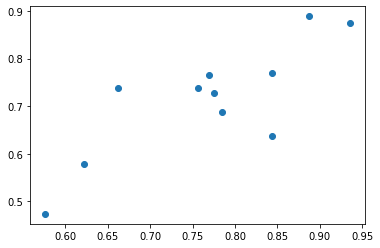

In [54]:
plt.plot([i[1] for i in uniform_sim_system_scores], [i[1] for i in satisfaction_scores], 'o')
print(kendalltau([i[1] for i in uniform_sim_system_scores], [i[1] for i in satisfaction_scores]))
print(spearmanr([i[1] for i in uniform_sim_system_scores], [i[1] for i in satisfaction_scores]))
print(pearsonr([i[1] for i in uniform_sim_system_scores], [i[1] for i in satisfaction_scores]))

In [55]:
topic_scores = []
for topic in tqdm(topics):
    num_subtopics = len(sub_topics[topic])

    all_r_documents = {}
    all_r_inverted_index = {}
    for sub_topic in sub_topics[topic]:
        r_documents, r_inverted_index = get_search_engine(topic, sub_topic, qrels, direct_index)
        all_r_documents[sub_topic] = r_documents
        all_r_inverted_index[sub_topic] = r_inverted_index

    transitions_table = get_transitions_table(num_subtopics, min(sub_topics[topic]), all_sequences[topic])

    scores = []
    for n in range(num_samples):
        sequence, prob = generate_sequence_from_table(num_subtopics, min(sub_topics[topic]), transitions_table)

        score = 0.0
        norm = 0.0
        for m, action in enumerate(sequence[:-1]):
            sub_topic = action[3]
            query = action[4]

            query = ''
            if sub_topic in all_queries[topic] and len(all_queries[topic][sub_topic]) > 0: 
                queries = list(all_queries[topic][sub_topic])
                query = queries[choice(range(len(queries)))]

            search = Search(all_r_inverted_index[sub_topic], pre_preocessor)
            answer = search.search(query, n=1, retrievable_paragraphs=all_r_documents[sub_topic].keys())[0]

            rel = 0.0
            if sub_topic in qrels_users[topic] and answer in qrels_users[topic][sub_topic]:
                rel = qrels_users[topic][sub_topic][answer]
                
            score += rel
            norm += 1
            
        scores.append(score/norm)

    if scores:
        scores = np.array(scores)
        topic_score = np.mean(scores)
        topic_scores.append((topic, topic_score))
    else:
        topic_scores.append((topic, 0.0))

table_sim_system_scores = sorted(topic_scores)
table_sim_system_scores

[(1, 0.7437401037997492),
 (2, 0.8429217110612505),
 (3, 0.9156898880639819),
 (4, 0.6151802303478404),
 (5, 0.5560026989095761),
 (6, 0.7956869347495237),
 (7, 0.8808547164028933),
 (8, 0.5659637771288897),
 (9, 0.809324200382674),
 (10, 0.7299627055983432),
 (11, 0.7780128695640071)]

KendalltauResult(correlation=0.6238794669049376, pvalue=0.007931923532795277)
SpearmanrResult(correlation=0.7881569423102951, pvalue=0.003956192304592836)
(0.816494700857465, 0.002165933135720271)


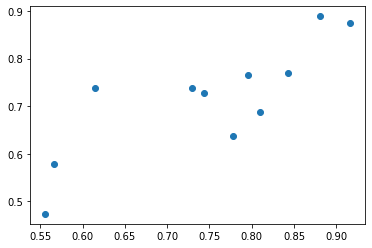

In [56]:
plt.plot([i[1] for i in table_sim_system_scores], [i[1] for i in satisfaction_scores], 'o')
print(kendalltau([i[1] for i in table_sim_system_scores], [i[1] for i in satisfaction_scores]))
print(spearmanr([i[1] for i in table_sim_system_scores], [i[1] for i in satisfaction_scores]))
print(pearsonr([i[1] for i in table_sim_system_scores], [i[1] for i in satisfaction_scores]))

In [57]:
topic_scores = []
for topic in tqdm(topics):
    num_subtopics = len(sub_topics[topic])

    all_r_documents = {}
    all_r_inverted_index = {}
    for sub_topic in sub_topics[topic]:
        r_documents, r_inverted_index = get_search_engine(topic, sub_topic, qrels, direct_index)
        all_r_documents[sub_topic] = r_documents
        all_r_inverted_index[sub_topic] = r_inverted_index

    rel_table, irr_table, p_rel, _ = get_transitions_tables(num_subtopics, min(sub_topics[topic]), all_sequences[topic], 0.01)

    # compute metric
    scores = []
    for n in range(num_samples):
        score = 0.0
        norm = 0.0
        sg = SequenceGenerator(num_subtopics, min(sub_topics[topic]), rel_table, irr_table)
        sequence = []
        for m, (sub_topic, prob_subtopic)  in enumerate(sg):
            if sub_topic != num_subtopics + 1 + min(sub_topics[topic]) - 1:
                prob *= prob_subtopic
                is_rel = False
                query = ''
                if sub_topic in all_queries[topic] and len(all_queries[topic][sub_topic]) > 0: 
                    queries = list(all_queries[topic][sub_topic])
                    query = queries[choice(range(len(queries)))]

                search = Search(all_r_inverted_index[sub_topic], pre_preocessor)
                answer = search.search(query, n=1, retrievable_paragraphs=all_r_documents[sub_topic].keys())[0]

                rel = 0.0
                if sub_topic in qrels_users[topic] and answer in qrels_users[topic][sub_topic]:
                    if np.random.uniform(0,1) < qrels_users[topic][sub_topic][answer]:
                        sg.set_relevance(True)
                        sequence.append((None, None, 'relevant', None, None))
                    else:
                        sg.set_relevance(False)
                        sequence.append((None, None, 'irrelevant', None, None))                        
                    rel = qrels_users[topic][sub_topic][answer]
                else:
                    sg.set_relevance(False)
                    sequence.append((None, None, 'irrelevant', None, None))
                
                
                score += rel
                norm += 1

        scores.append(score/norm)

    if scores:
        scores = np.array(scores)
        topic_score = np.mean(scores)
        topic_scores.append((topic, topic_score))
    else:
        topic_scores.append((topic, 0.0))

system_scores = sorted(topic_scores)

system_scores

KeyboardInterrupt: 

In [ ]:
plt.plot([i[1] for i in system_scores], [i[1] for i in satisfaction_scores], 'o')
print(kendalltau([i[1] for i in system_scores], [i[1] for i in satisfaction_scores]))
print(spearmanr([i[1] for i in system_scores], [i[1] for i in satisfaction_scores]))
print(pearsonr([i[1] for i in system_scores], [i[1] for i in satisfaction_scores]))



In [ ]:
plt.plot([i[1] for i in system_scores], [i[1] for i in ncbp_p_scores], 'o')
print(kendalltau([i[1] for i in system_scores], [i[1] for i in ncbp_p_scores]))
print(spearmanr([i[1] for i in system_scores], [i[1] for i in ncbp_p_scores]))
print(pearsonr([i[1] for i in system_scores], [i[1] for i in ncbp_p_scores]))

In [ ]:
# comparison of a system with without filtering, or with noise
# compute transition on sessions using the transition probabilities.
noise = 0.0

means = []
for noise in tqdm(range(0, 11)):
    noise = noise/10

    topic_scores = []

    for topic in topics:
        num_subtopics = len(sub_topics[topic])

        all_r_documents = {}
        all_r_inverted_index = {}
        for sub_topic in sub_topics[topic]:
            r_documents, r_inverted_index = get_search_engine(topic, sub_topic, qrels, direct_index, noise)
            all_r_documents[sub_topic] = r_documents
            all_r_inverted_index[sub_topic] = r_inverted_index

        rel_table, irr_table, p_rel, _ = get_transitions_tables(num_subtopics, min(sub_topics[topic]), all_sequences[topic], 0.01)

        # compute metric
        scores = []
        for n in range(50):
            score = 0.0
            norm = 0.0
            sg = SequenceGenerator(num_subtopics, min(sub_topics[topic]), rel_table, irr_table)
            sequence = []
            for m, (sub_topic, prob_subtopic)  in enumerate(sg):
                if sub_topic != num_subtopics + 1 + min(sub_topics[topic]) - 1:
                    prob *= prob_subtopic
                    is_rel = False
                    query = ''
                    if sub_topic in all_queries[topic] and len(all_queries[topic][sub_topic]) > 0: 
                        queries = list(all_queries[topic][sub_topic])
                        query = queries[choice(range(len(queries)))]

                    search = Search(all_r_inverted_index[sub_topic], pre_preocessor)
                    answer = search.search(query, n=1, retrievable_paragraphs=all_r_documents[sub_topic].keys())[0]

                    rel = 0.0
                    if sub_topic in qrels_users[topic] and answer in qrels_users[topic][sub_topic] and np.random.uniform(0,1) < qrels_users[topic][sub_topic][answer]:
                        sg.set_relevance(True)
                        sequence.append((None, None, 'relevant', None, None))
                        rel = qrels_users[topic][sub_topic][answer]
                    else:
                        sg.set_relevance(False)
                        sequence.append((None, None, 'irrelevant', None, None))

                    score += dd_cbp_p(alpha, beta, m, sequence) * rel
                    norm += dd_cbp_p(alpha, beta, m, sequence)
            scores.append(score/norm)

        if scores:
            scores = np.array(scores)
            topic_score = np.mean(scores)
            topic_scores.append(topic_score)
        else:
            topic_scores.append(0.0)

    system_scores = np.mean(topic_scores)
    
    means.append((noise, system_scores))
    
means


In [ ]:
plt.plot([i[0] for i in means], [i[1] for i in means], 'o')

In [ ]:
plt.plot([i[1] for i in system_scores], [i[1] for i in satisfaction_scores], 'o')
print(kendalltau([i[1] for i in system_scores], [i[1] for i in satisfaction_scores]))

In [ ]:
plt.plot([i[1] for i in uniform_sim_system_scores], [i[1] for i in system_scores], 'o')
print(kendalltau([i[1] for i in uniform_sim_system_scores], [i[1] for i in system_scores]))

In [ ]:
plt.plot([i[1] for i in table_sim_system_scores], [i[1] for i in system_scores], 'o')
print(kendalltau([i[1] for i in table_sim_system_scores], [i[1] for i in system_scores]))

In [ ]:
plt.plot([i[1] for i in system_scores], [i[1] for i in satisfaction_scores], 'o')
print(kendalltau([i[1] for i in system_scores], [i[1] for i in satisfaction_scores]))